# Inicio

In [1]:
import os

os.environ["LOKY_MAX_CPU_COUNT"] = "8"

In [36]:
# Bibliotecas fundamentais
import numpy as np
import pandas as pd

# Bibliotecas gráficas
import matplotlib.pyplot as plt
import seaborn as sns

# Data Science
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate, GridSearchCV, StratifiedKFold, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    OrdinalEncoder,
    OneHotEncoder,
    PowerTransformer,
    StandardScaler,
)

# Classificadores
# referência
from sklearn.dummy import DummyClassifier

# lineares
from sklearn.linear_model import Perceptron, LogisticRegression, SGDClassifier

# árvores
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.inspection import permutation_importance

# SVM
from sklearn.svm import SVC

# kNN
from sklearn.neighbors import KNeighborsClassifier


# Configurações e importações gerais
from src.auxiliares import dataframe_coeficientes
from src.config import DADOS_TRATADOS
from src.graficos import plot_comparar_metricas_modelos, plot_coeficientes
from src.models import RANDOM_STATE
from src.models import (
    grid_search_cv_classificador,
    treinar_e_validar_modelo_classificacao,
    organiza_resultados,
)

sns.set_theme(palette="bright")

# Exportar o modelo
from src.config import MODELO_FINAL
from joblib import dump


In [3]:
df = pd.read_parquet(DADOS_TRATADOS)


with pd.option_context("display.max_columns", 35):
    display(df.head())

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Yes,11,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,No,23,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Yes,15,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Yes,11,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,No,12,3,4,1,6,3,3,2,2,2,2


In [4]:
colunas_categoricas_nao_ordenadas = [
    "BusinessTravel",
    "Department",
    "EducationField",
    "Gender",
    "JobRole",
    "MaritalStatus",
    "OverTime",
]

colunas_categoricas_ordenadas = [
    "Education",
    "EnvironmentSatisfaction",
    "JobSatisfaction",
    "JobInvolvement",
    "JobLevel",
    "PerformanceRating",
    "RelationshipSatisfaction",
    "StockOptionLevel",
    "WorkLifeBalance",
]

coluna_alvo = ["Attrition"]

colunas_numericas = [
    coluna for coluna in df.columns if coluna not in (
        colunas_categoricas_nao_ordenadas + colunas_categoricas_ordenadas + coluna_alvo
    )
]

## Padronização das colunas

In [5]:
# Colunas com distribuição pouco definida merecem um tratamento de escala mais simples

cols_min_max = [
    'DailyRate',
    'HourlyRate',
    'MonthlyRate',
]

# Colunas com distribuição próximas da normal, porém com leve distorção ou assimetria
cols_std = ["Age"]

# Colunas com maiores assimetrias e distorções merecem tratamento de normalização mais agressivo 
cols_pwr_tr = [c for c in colunas_numericas
               if c not in cols_min_max + cols_std]

# Estudo Inicial dos Modelos

## Preparação inicial

In [6]:
X = df.drop(columns=coluna_alvo)
y = df[coluna_alvo]

In [7]:
le = LabelEncoder()
y = le.fit_transform(y.values.ravel())

print(y[:5], le.classes_)

[1 0 1 0 0] ['No' 'Yes']


Note que a **classe positiva** significa o `Attrition` (saída do funcionário da empresa) e a **classe negativa** a permanência

In [8]:
kf = StratifiedKFold(n_splits=5,
                     shuffle=True,
                     random_state=RANDOM_STATE)

## Preparação dos modelos

In [9]:
# Preprocessamento

preprocessamento_arvore = ColumnTransformer(
    transformers=[
        ("one_hot", OneHotEncoder(drop='first'), colunas_categoricas_nao_ordenadas),
        ("ordinal", OrdinalEncoder(categories='auto'), colunas_categoricas_ordenadas),
    ]
)

preprocessamento = ColumnTransformer(
    transformers=[
        ("one_hot", OneHotEncoder(drop='first'), colunas_categoricas_nao_ordenadas),
        ("ordinal", OrdinalEncoder(categories='auto'), colunas_categoricas_ordenadas),
        ("min_max", MinMaxScaler(), cols_min_max),
        ("stdscaler", StandardScaler(), cols_std),
        ("power_transform", PowerTransformer(), cols_pwr_tr),
    ]
)

In [10]:
# Classificadores

scale_pos_weight = np.bincount(y)[0] / np.bincount(y)[1] # Padronizador para tratar base desbalanceada em modelos específicos (sem o parâmetro strategy).


classificadores = {

    # Referência
    "DummyClassifier": {
        "preprocessor": None,
        "classificador": DummyClassifier(strategy="stratified"),
    },


    # Lineares
    "Perceptron": {
        "preprocessor": preprocessamento,
        "classificador": Perceptron(class_weight='balanced',
                                    n_jobs=-1)
    },

    "LogisticRegression": {
        "preprocessor": preprocessamento,
        "classificador": LogisticRegression(class_weight="balanced") 
        # n_jobs inútil para classificação binária. 

        ## Na classificação binária, o LogisticRegression precisa treinar apenas um classificador.
        ## A otimização (solver) desse classificador é majoritariamente sequencial. 
        ## O n_jobs não consegue distribuir o cálculo de uma única função de custo por todos os núcleos.
    },

    "SGDClassifier": {
        "preprocessor": preprocessamento,
        "classificador": SGDClassifier(random_state=RANDOM_STATE,
                                       class_weight='balanced',
                                       n_jobs=-1)
    },


    # Árvore de Decisão
    "DecisionTreeClassifier": {
        "preprocessor": preprocessamento_arvore,
        "classificador": DecisionTreeClassifier(random_state=RANDOM_STATE,
                                                class_weight='balanced')
    },
    
    "ExtraTreesClassifier": {
        "preprocessor": preprocessamento_arvore,
        "classificador": ExtraTreesClassifier(random_state=RANDOM_STATE,
                                              class_weight='balanced',
                                              n_jobs=-1)
    },

    "RandomForestClassifier": {
        "preprocessor": preprocessamento_arvore,
        "classificador": RandomForestClassifier(random_state=RANDOM_STATE,
                                                class_weight='balanced',
                                                n_jobs=-1)
    },

    "XGBClassifier": {
        "preprocessor": preprocessamento_arvore,
        "classificador": XGBClassifier(random_state=RANDOM_STATE,
                                        n_jobs=-1,
                                        scale_pos_weight=scale_pos_weight)
    },

    "LGBMClassifier": {
        "preprocessor": preprocessamento_arvore,
        "classificador": LGBMClassifier(random_state=RANDOM_STATE,
                                        n_jobs=-1,
                                        verbose=-1,
                                        scale_pos_weight=scale_pos_weight)
    },
  
    # Outros
    "SVC": {
        "preprocessor": preprocessamento,
        "classificador": SVC(class_weight='balanced')
    },

    "KNeighborsClassifier": {
        "preprocessor": preprocessamento,
        "classificador": KNeighborsClassifier()
    },

}

In [11]:
# Dicionário de resultados
dict_resultados = {}

for modelo, classificador in classificadores.items():

    # criando a pipiline
    pipeline = Pipeline([
        ('preprocessor', classificador['preprocessor']),
        (modelo, classificador['classificador'])
    ])

    # cross validate

    scores = cross_validate(
        estimator=pipeline, 
        X=X, y=y,
        cv=kf,
        scoring=[
            "accuracy",
            "balanced_accuracy",
            "f1",
            "precision",
            "recall",
            "roc_auc",
            "average_precision",
        ],
    )

    dict_resultados[modelo] = scores

dict_resultados['KNeighborsClassifier']


{'fit_time': array([0.02303004, 0.02754879, 0.0230329 , 0.0265348 , 0.0265398 ]),
 'score_time': array([0.11085391, 0.03573656, 0.03705311, 0.03905034, 0.0370996 ]),
 'test_accuracy': array([0.84013605, 0.85034014, 0.8537415 , 0.84353741, 0.8537415 ]),
 'test_balanced_accuracy': array([0.56072154, 0.55005081, 0.54255319, 0.52786631, 0.56839521]),
 'test_f1': array([0.2295082 , 0.18518519, 0.15686275, 0.11538462, 0.24561404]),
 'test_precision': array([0.53846154, 0.83333333, 1.        , 0.6       , 0.7       ]),
 'test_recall': array([0.14583333, 0.10416667, 0.08510638, 0.06382979, 0.14893617]),
 'test_roc_auc': array([0.73039465, 0.63533198, 0.74950469, 0.60440176, 0.61607374]),
 'test_average_precision': array([0.35515719, 0.30615345, 0.38403012, 0.248799  , 0.2870104 ])}

In [12]:
# df manual

## Cria o df
df_resultados = pd.DataFrame(dict_resultados).T.reset_index().rename(columns={'index' : 'model'})

## expande os valores para linhas (antes, cada regirstro tinha todas as métricas em uma só linha)
df_resultados = df_resultados.explode(column=df_resultados.columns[1:].to_list()).reset_index(drop=True)

## marcador de tempo
df_resultados["time_seconds"] = df_resultados["fit_time"] + df_resultados["score_time"]

## transforma as métricas em numérico
for c in df_resultados.columns[1:]:

    df_resultados[c] = pd.to_numeric(df_resultados[c], errors='coerce')

df_resultados.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55 entries, 0 to 54
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   model                   55 non-null     object 
 1   fit_time                55 non-null     float64
 2   score_time              55 non-null     float64
 3   test_accuracy           55 non-null     float64
 4   test_balanced_accuracy  55 non-null     float64
 5   test_f1                 55 non-null     float64
 6   test_precision          55 non-null     float64
 7   test_recall             55 non-null     float64
 8   test_roc_auc            55 non-null     float64
 9   test_average_precision  55 non-null     float64
 10  time_seconds            55 non-null     float64
dtypes: float64(10), object(1)
memory usage: 4.9+ KB


In [13]:
df_resultados.groupby("model").mean().sort_values("test_average_precision")

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
model,,,,,,,,,,
DummyClassifier,0.001202,0.004708,0.742177,0.500181,0.151310,0.160901,0.143085,0.523213,0.170444,0.005909
DecisionTreeClassifier,0.009904,0.011020,0.783673,0.603238,0.332944,0.329691,0.337057,0.603238,0.220891,0.020925
KNeighborsClassifier,0.025337,0.051959,0.848299,0.549917,0.186511,0.734359,0.109574,0.667141,0.316230,0.077296
Perceptron,0.025331,0.024466,0.708163,0.659893,0.404044,0.360725,0.589273,0.746768,0.433267,0.049797
ExtraTreesClassifier,0.096428,0.048959,0.851701,0.599715,0.330554,0.619406,0.227837,0.768654,0.451977,0.145387
XGBClassifier,0.120596,0.017127,0.826531,0.664686,0.441594,0.459649,0.425887,0.777781,0.468712,0.137722
SGDClassifier,0.024458,0.016965,0.774150,0.696382,0.467914,0.434545,0.581738,0.782546,0.495606,0.041423
RandomForestClassifier,0.115368,0.046957,0.856463,0.585428,0.289241,0.691500,0.185461,0.796255,0.497107,0.162325
LGBMClassifier,0.044947,0.015025,0.823129,0.684999,0.467428,0.454588,0.481117,0.792950,0.497247,0.059972


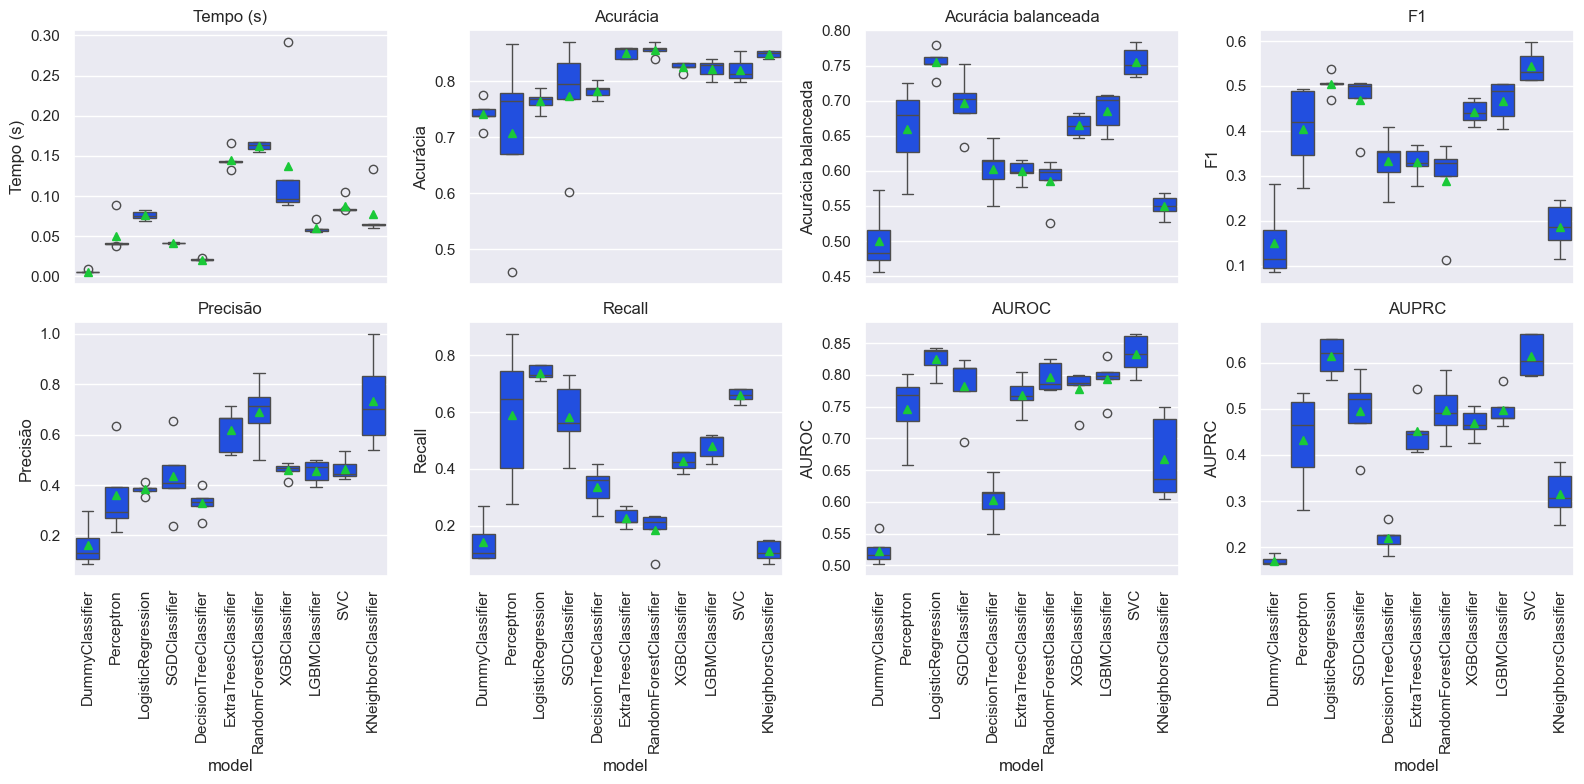

In [14]:
# fazer o boxplot

# boxplots

fig, axs = plt.subplots(2, 4, 
                        figsize=(16, 8), 
                         sharex=True)

comparar_metricas = [
        "time_seconds",
        "test_accuracy",
        "test_balanced_accuracy",
        "test_f1",
        "test_precision",
        "test_recall",
        "test_roc_auc",
        "test_average_precision",
    ]

nomes_metricas = [
        "Tempo (s)",
        "Acurácia",
        "Acurácia balanceada",
        "F1",
        "Precisão",
        "Recall",
        "AUROC",
        "AUPRC",
    ]


for ax, metrica, nome in zip(axs.flatten(), comparar_metricas, nomes_metricas):

    sns.boxplot(
        # dados
        data=df_resultados,

        # nome do eixo x: "model"  
        x='model',

        # nome da métrica no eixo y
        y=metrica,

        # qual eixo?
        ax=ax,

        # mostre as médias!
        showmeans=True

    )

    # como colocar o título variando com o gráfico?
    ax.set_title(nome)

    # como colocar o rótulo do eixo y?
    ax.set_ylabel(nome)


    # rode os ródutlos do eixo 'x' para 90
    ax.tick_params(axis='x', rotation=90)


plt.tight_layout()
plt.show()

- Caso de escolha de um único Modelo

1. LogisticRegression e SVC foram, detre todos, os melhores na métrica de referência (AUPRC)
2. LogisticRegression e SVC foram, detre todos, os melhores ao acertar a classe positiva (Recall) e com menor variação de resultados. LogisticRegression levemente melhor.
3. LogisticRegression é mais rápido;
4. LogisticRegression é mais simples de explicar;


- Caso de escolha de mais de um Modelo

1. LogisticRegression e SVC foram, detre todos, os melhores na métrica de referência (AUPRC)
2. LogisticRegression e SVC foram, detre todos, os melhores ao acertar a classe positiva (Recall) e com menor variação de resultados. LogisticRegression levemente melhor.
3. Modelos rápidos de treinar.
4. Modelos relativamente simples.
5. Vantagem de avaliar o _tuning_ para dois modelos diferentes e entender melhor a natureza da base.



# Estudo do modelo mais promissor

In [15]:
# param grid para o modelo em estudo

param_grid = [

# Parâmetros gerais
{    
    "classificador__C" : [0.1, 1, 10, 100],
    "classificador__penalty" : ["l1", "l2", None],
},

# Parâmetros elasticnet
{    
    "classificador__C" : [0.1, 1, 10, 100],
    "classificador__penalty" : ["elasticnet"],
    'classificador__l1_ratio' : [0.1, 0.25, 0.5, 0.75, 0.9]
}

]

clf = LogisticRegression(solver='saga',
                         random_state=RANDOM_STATE,
                         class_weight='balanced')

In [16]:
refit_metric = 'average_precision'

# Criando a pipiline
pipeline = Pipeline([
    ('preprocessor', preprocessamento),
    ('classificador', clf)
])

# Criando o GridSearch
grid_search = GridSearchCV(
    estimator=pipeline,
    cv=kf,
    param_grid=param_grid,
    scoring=[
        "accuracy",
        "balanced_accuracy",
        "f1",
        "precision",
        "recall",
        "roc_auc",
        "average_precision",
    ],
    refit=refit_metric,
    n_jobs=-1,
    return_train_score=False,
    verbose=1,
)

grid_search

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('one_hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['BusinessTravel',
                                                                          'Department',
                                                                          'EducationField',
                                                                          'Gender',
                                                                          'JobRole',
                                                                          'MaritalStatus',
                                                                          'OverTime']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(),
                                                                         ['Education',
                                                                          'EnvironmentSatisfaction',
                                                                          '...
             param_grid=[{'classificador__C': [0.1, 1, 10, 100],
                          'classificador__penalty': ['l1', 'l2', None]},
                         {'classificador__C': [0.1, 1, 10, 100],
                          'classificador__l1_ratio': [0.1, 0.25, 0.5, 0.75,
                                                      0.9],
                          'classificador__penalty': ['elasticnet']}],
             refit='average_precision',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision'],
             verbose=1)

In [17]:
grid_search.fit(X, y)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('one_hot',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['BusinessTravel',
                                                                          'Department',
                                                                          'EducationField',
                                                                          'Gender',
                                                                          'JobRole',
                                                                          'MaritalStatus',
                                                                          'OverTime']),
                                                                        ('ordinal',
                                                                         OrdinalEncoder(),
                                                                         ['Education',
                                                                          'EnvironmentSatisfaction',
                                                                          '...
             param_grid=[{'classificador__C': [0.1, 1, 10, 100],
                          'classificador__penalty': ['l1', 'l2', None]},
                         {'classificador__C': [0.1, 1, 10, 100],
                          'classificador__l1_ratio': [0.1, 0.25, 0.5, 0.75,
                                                      0.9],
                          'classificador__penalty': ['elasticnet']}],
             refit='average_precision',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision'],
             verbose=1)

In [18]:
grid_search.best_params_

{'classificador__C': 0.1,
 'classificador__l1_ratio': 0.5,
 'classificador__penalty': 'elasticnet'}

In [19]:
grid_search.best_score_

np.float64(0.6349983962539747)

In [20]:
grid_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['BusinessTravel',
                                                   'Department',
                                                   'EducationField', 'Gender',
                                                   'JobRole', 'MaritalStatus',
                                                   'OverTime']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['Education',
                                                   'EnvironmentSatisfaction',
                                                   'JobSatisfaction',
                                                   'JobInvolvement', 'JobLevel',
                                                   'PerformanceRating',
                                                   'RelationshipSatis...
                                                  PowerTransformer(),
                                                  ['DistanceFromHome',
                                                   'MonthlyIncome',
                                                   'NumCompaniesWorked',
                                                   'PercentSalaryHike',
                                                   'TotalWorkingYears',
                                                   'TrainingTimesLastYear',
                                                   'YearsAtCompany',
                                                   'YearsInCurrentRole',
                                                   'YearsSinceLastPromotion',
                                                   'YearsWithCurrManager'])])),
                ('classificador',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    l1_ratio=0.5, penalty='elasticnet',
                                    random_state=42, solver='saga'))])

In [21]:
grid_search.best_estimator_["preprocessor"].get_feature_names_out()

array(['one_hot__BusinessTravel_Travel_Frequently',
       'one_hot__BusinessTravel_Travel_Rarely',
       'one_hot__Department_Research & Development',
       'one_hot__Department_Sales',
       'one_hot__EducationField_Life Sciences',
       'one_hot__EducationField_Marketing',
       'one_hot__EducationField_Medical', 'one_hot__EducationField_Other',
       'one_hot__EducationField_Technical Degree', 'one_hot__Gender_Male',
       'one_hot__JobRole_Human Resources',
       'one_hot__JobRole_Laboratory Technician',
       'one_hot__JobRole_Manager',
       'one_hot__JobRole_Manufacturing Director',
       'one_hot__JobRole_Research Director',
       'one_hot__JobRole_Research Scientist',
       'one_hot__JobRole_Sales Executive',
       'one_hot__JobRole_Sales Representative',
       'one_hot__MaritalStatus_Married', 'one_hot__MaritalStatus_Single',
       'one_hot__OverTime_Yes', 'ordinal__Education',
       'ordinal__EnvironmentSatisfaction', 'ordinal__JobSatisfaction',
       'ord

In [22]:
grid_search.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_classificador__C', 'param_classificador__penalty', 'param_classificador__l1_ratio', 'params', 'split0_test_accuracy', 'split1_test_accuracy', 'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy', 'mean_test_accuracy', 'std_test_accuracy', 'rank_test_accuracy', 'split0_test_balanced_accuracy', 'split1_test_balanced_accuracy', 'split2_test_balanced_accuracy', 'split3_test_balanced_accuracy', 'split4_test_balanced_accuracy', 'mean_test_balanced_accuracy', 'std_test_balanced_accuracy', 'rank_test_balanced_accuracy', 'split0_test_f1', 'split1_test_f1', 'split2_test_f1', 'split3_test_f1', 'split4_test_f1', 'mean_test_f1', 'std_test_f1', 'rank_test_f1', 'split0_test_precision', 'split1_test_precision', 'split2_test_precision', 'split3_test_precision', 'split4_test_precision', 'mean_test_precision', 'std_test_precision', 'rank_test_precision', 'split0_test_recall', 'split1_test_recall', 's

In [23]:
grid_search.cv_results_['mean_test_average_precision']

array([0.62950261, 0.63097957, 0.60276858, 0.61727037, 0.61333292,
       0.60276858, 0.60385672, 0.60368385, 0.60276858, 0.60282964,
       0.60283747, 0.60276858, 0.63244577, 0.63430512, 0.6349984 ,
       0.63364338, 0.63132075, 0.61422885, 0.61485593, 0.6162751 ,
       0.6160852 , 0.61686867, 0.60357434, 0.60354616, 0.60370398,
       0.60358031, 0.60390228, 0.60283747, 0.60283747, 0.60286095,
       0.60282964, 0.60282964])

In [24]:
grid_search.cv_results_['mean_test_average_precision'][grid_search.best_index_]

np.float64(0.6349983962539747)

In [25]:
colunas_test = [c for c in df_resultados.columns
                if c.startswith('test')]
colunas_test

['test_accuracy',
 'test_balanced_accuracy',
 'test_f1',
 'test_precision',
 'test_recall',
 'test_roc_auc',
 'test_average_precision']

In [26]:
colunas_test_mean = ['mean_' + c for c in colunas_test]
colunas_test_mean

['mean_test_accuracy',
 'mean_test_balanced_accuracy',
 'mean_test_f1',
 'mean_test_precision',
 'mean_test_recall',
 'mean_test_roc_auc',
 'mean_test_average_precision']

In [27]:
for c in colunas_test_mean:
    print(f'coluna {c}: {round(grid_search.cv_results_[c][grid_search.best_index_], 2)}')


coluna mean_test_accuracy: 0.76
coluna mean_test_balanced_accuracy: 0.75
coluna mean_test_f1: 0.5
coluna mean_test_precision: 0.38
coluna mean_test_recall: 0.73
coluna mean_test_roc_auc: 0.82
coluna mean_test_average_precision: 0.63


In [28]:
grid_search.best_estimator_['classificador'].coef_

array([[ 0.74769661,  0.16822999, -0.33921839,  0.25504817, -0.16290104,
         0.        , -0.05777659,  0.        ,  0.44970591,  0.19501108,
         0.        ,  0.32540051,  0.        ,  0.        ,  0.        ,
        -0.18228752,  0.        ,  0.10981253,  0.09031785,  0.60912064,
         1.34864453,  0.        , -0.32713283, -0.29696249, -0.40820171,
         0.03873573,  0.        , -0.15590379, -0.19637859, -0.20555839,
        -0.21753069,  0.        ,  0.        , -0.07416628,  0.23899622,
        -0.40024778,  0.31527531, -0.11942992, -0.28845353, -0.18323944,
         0.15558071, -0.22939617,  0.30882176, -0.22676348]])

In [29]:
coefs = pd.DataFrame(
    data=grid_search.best_estimator_['classificador'].coef_[0],
    index=grid_search.best_estimator_['preprocessor'].get_feature_names_out(),
    columns=['Coeficientes']
).sort_values(by='Coeficientes', ascending=False)

coefs

,Coeficientes
one_hot__OverTime_Yes,1.348645
one_hot__BusinessTravel_Travel_Frequently,0.747697
one_hot__MaritalStatus_Single,0.609121
one_hot__EducationField_Technical Degree,0.449706
one_hot__JobRole_Laboratory Technician,0.325401
power_transform__NumCompaniesWorked,0.315275
power_transform__YearsSinceLastPromotion,0.308822
one_hot__Department_Sales,0.255048
power_transform__DistanceFromHome,0.238996
one_hot__Gender_Male,0.195011


In [30]:
coefs[coefs.values == 0]

,Coeficientes
one_hot__JobRole_Sales Executive,0.0
one_hot__EducationField_Marketing,0.0
one_hot__EducationField_Other,0.0
ordinal__Education,0.0
one_hot__JobRole_Human Resources,0.0
min_max__HourlyRate,0.0
one_hot__JobRole_Research Director,0.0
one_hot__JobRole_Manufacturing Director,0.0
min_max__MonthlyRate,0.0
ordinal__PerformanceRating,0.0


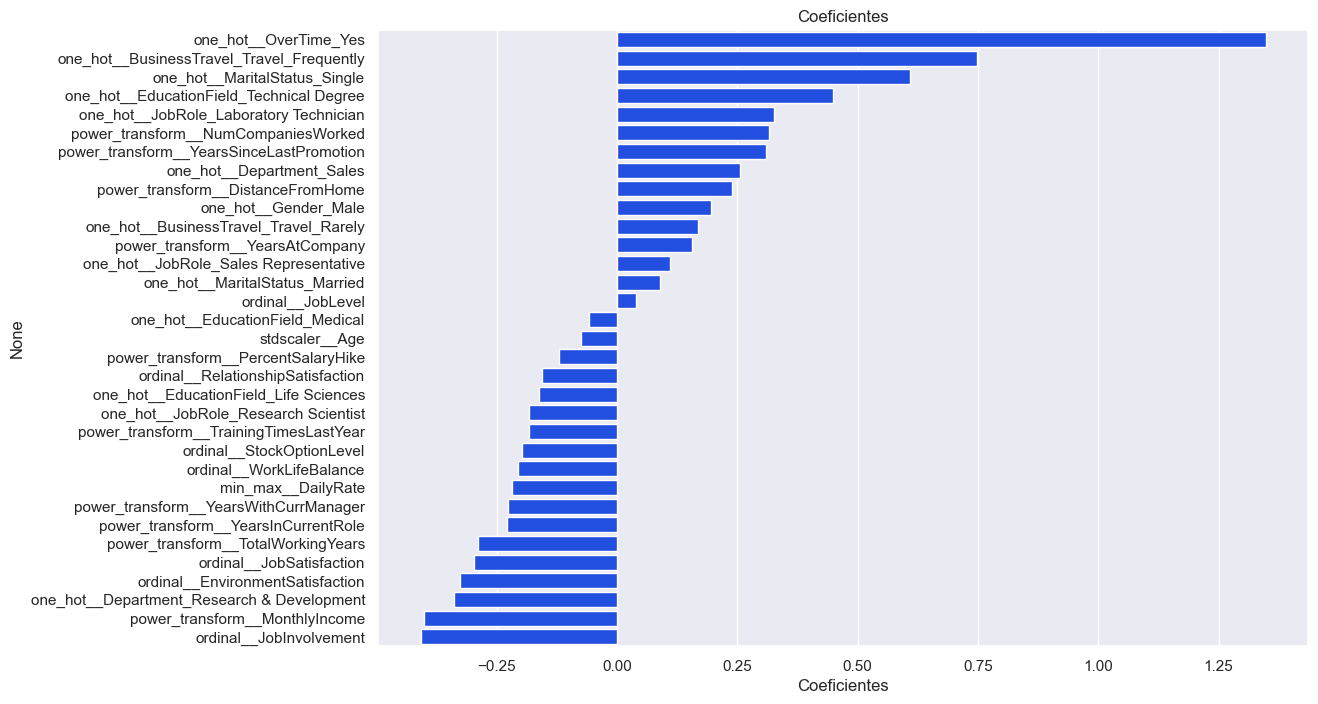

In [31]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.barplot(
    data=coefs[coefs.values != 0],
    x='Coeficientes',
    y=coefs[coefs.values != 0].index,
    ax=ax
)


plt.title("Coeficientes")
plt.show()

Os coeficientes $w_i$ em uma regressão logística não são interpretados diretamente como em uma regressão linear. Em vez disso, eles representam o **logaritmo do odds ratio** associado a cada variável.

- **Odds (Chances):** Razão entre a probabilidade do evento ocorrer e a probabilidade de não ocorrer.

  $$
  \text{Odds} = \frac{\text{Probabilidade do Evento}}{1 - \text{Probabilidade do Evento}}
  $$

- **Odds Ratio:** Medida de quanto as chances mudam com uma unidade de aumento na variável independente.

- **Coeficiente ($w_i$):** Representa a mudança nos **log-odds** do resultado por unidade de aumento na variável $X_i$.

  $$
  \text{Log-Odds} = w_0 + w_1X_1 + w_2X_2 + \dots + w_nX_n
  $$

Para interpretar os coeficientes em termos mais intuitivos, podemos calcular o **exponencial do coeficiente**:

$$
\text{Odds Ratio} = e^{w_i}
$$

- **Interpretação do Odds Ratio:**
  - **Valor > 1:** Aumenta as chances do evento ocorrer.
  - **Valor = 1:** Não afeta as chances.
  - **Valor < 1:** Diminui as chances do evento ocorrer.


Imagine que estamos modelando a probabilidade de um paciente ter uma doença com base na idade e no hábito de fumar.

$$
\text{Log-Odds} = w_0 + w_1 (\text{Idade}) + w_2 (\text{Fumante})
$$

Suponha que obtivemos os seguintes coeficientes:

- $w_0 = -2$
- $w_1 = 0{,}05$
- $w_2 = 1{,}5$

1. **Coeficiente da Idade ($w_1 = 0{,}05$):**

   - **Log-Odds:** Para cada aumento de 1 ano na idade, o log-odds de ter a doença aumenta em 0,05.
   - **Odds Ratio:** $e^{0{,}05} \approx 1{,}051$
   - **Interpretação:** Cada ano adicional de idade aumenta as chances de ter a doença em aproximadamente **5,1%**.

2. **Coeficiente do Fumante ($w_2 = 1{,}5$):**

   - **Log-Odds:** Se o paciente é fumante (1), o log-odds de ter a doença aumenta em 1,5 em comparação com não fumantes (0).
   - **Odds Ratio:** $e^{1{,}5} \approx 4{,}48$
   - **Interpretação:** Fumantes têm **4,48 vezes** mais chances de ter a doença do que não fumantes.


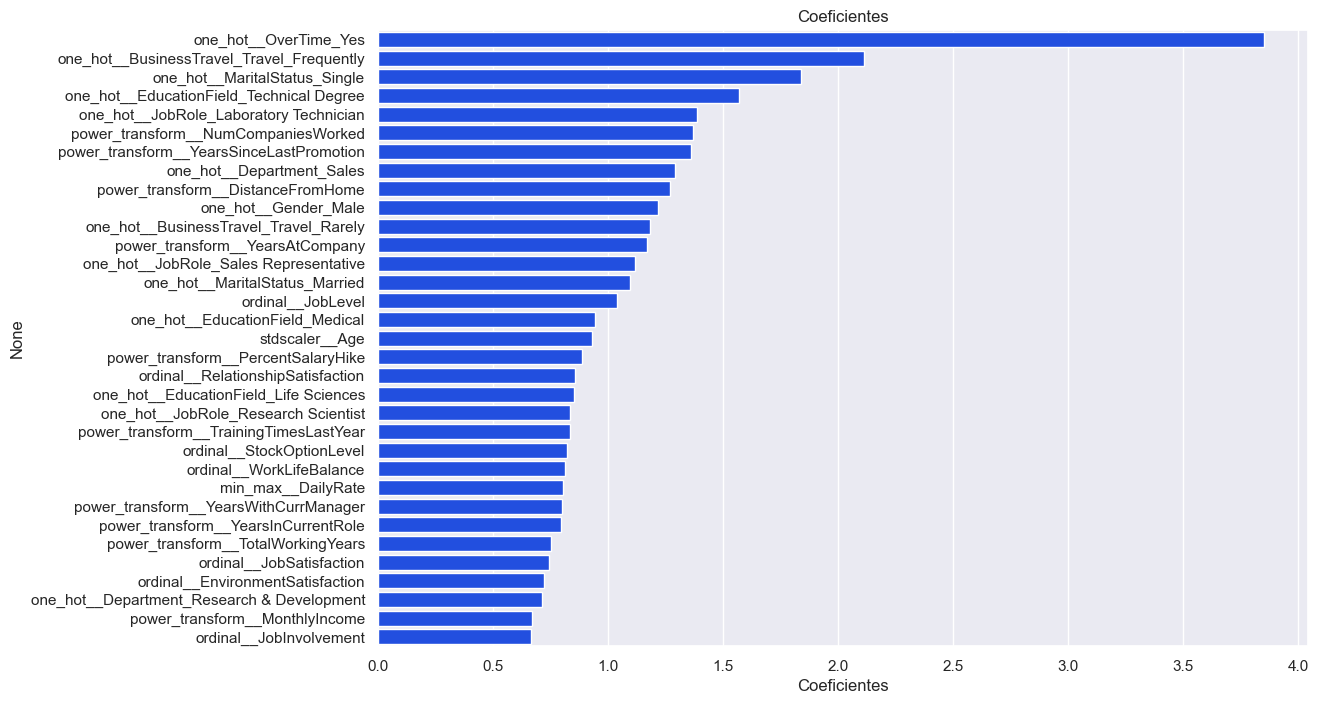

In [32]:
df_exp = coefs.copy()
df_exp['Coeficientes'] = np.exp(df_exp['Coeficientes'])

fig, ax = plt.subplots(figsize=(12, 8))

sns.barplot(
    data=df_exp[df_exp.values !=1],
    x='Coeficientes',
    y=df_exp[df_exp.values !=1].index,
    ax=ax
)


plt.title("Coeficientes")
plt.show()

Tendencia de sair na empresa

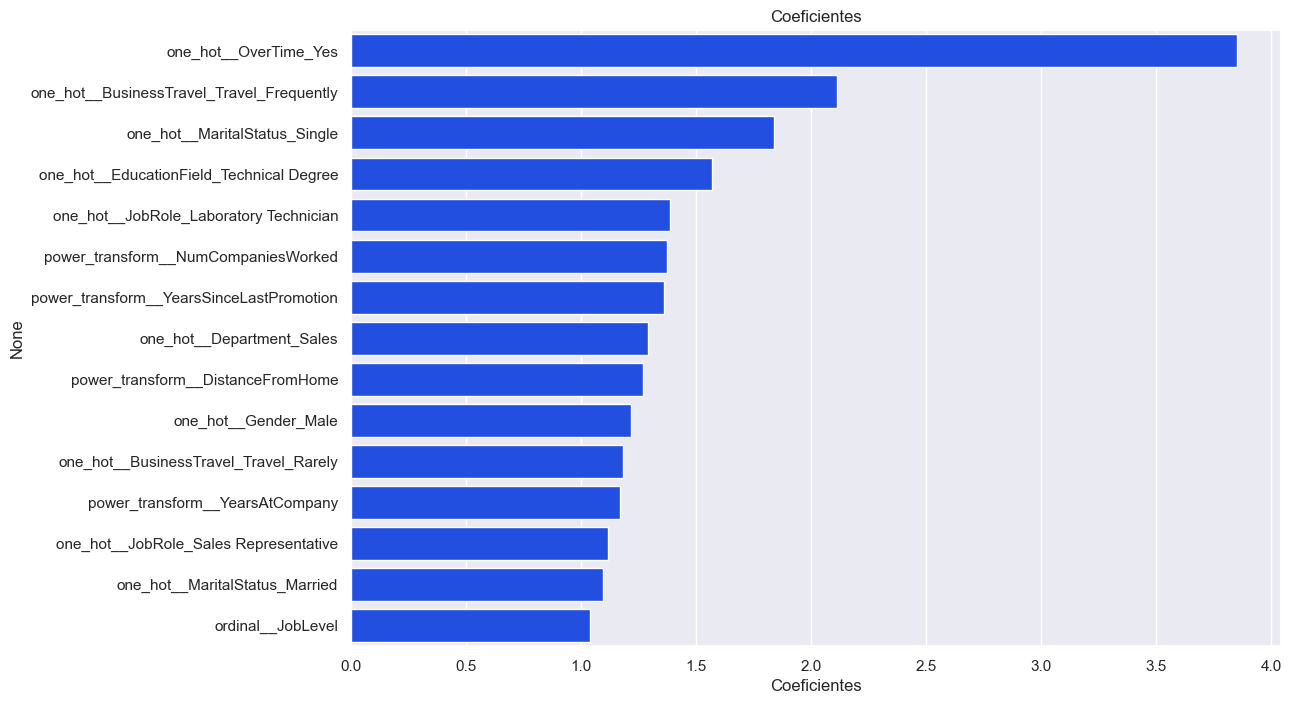

In [33]:
df_exp = coefs.copy()
df_exp['Coeficientes'] = np.exp(df_exp['Coeficientes'])

fig, ax = plt.subplots(figsize=(12, 8))

sns.barplot(
    data=df_exp[df_exp.values > 1],
    x='Coeficientes',
    y=df_exp[df_exp.values > 1].index,
    ax=ax
)


plt.title("Coeficientes")
plt.show()

Tendencia de se manter na empresa

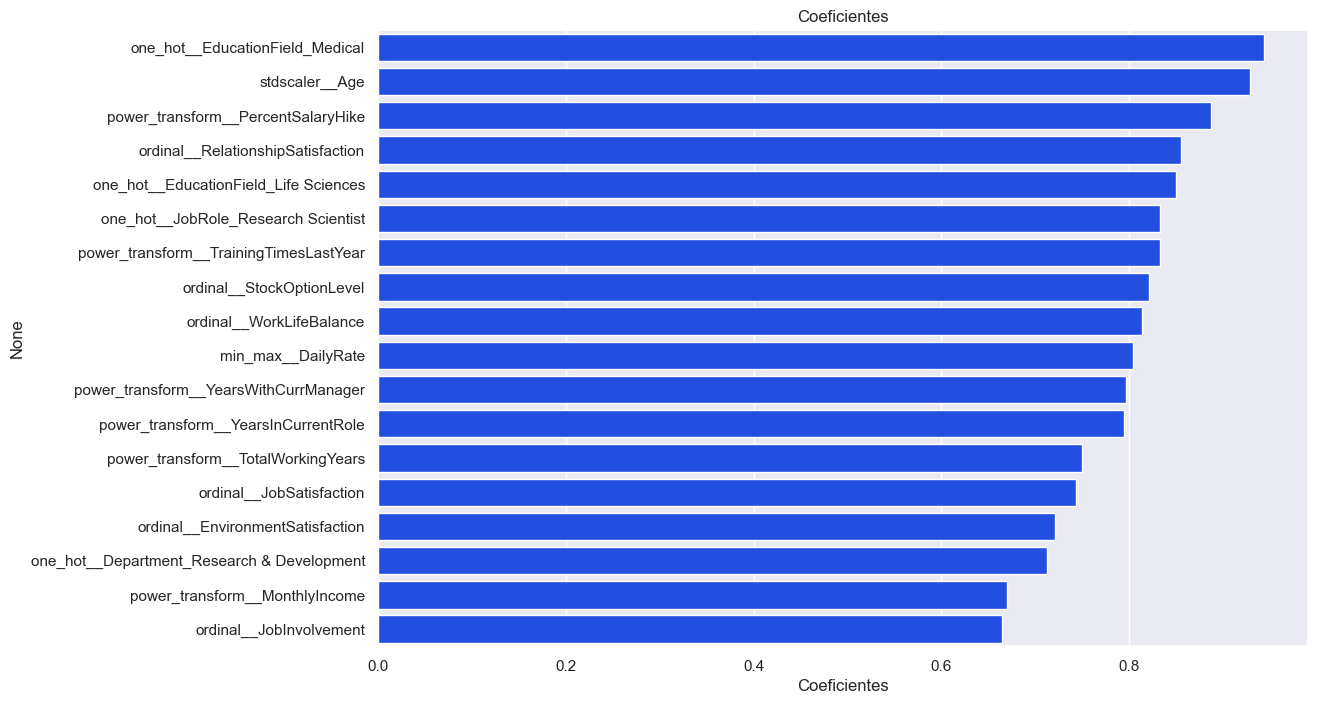

In [34]:
df_exp = coefs.copy()
df_exp['Coeficientes'] = np.exp(df_exp['Coeficientes'])

fig, ax = plt.subplots(figsize=(12, 8))

sns.barplot(
    data=df_exp[df_exp.values <1],
    x='Coeficientes',
    y=df_exp[df_exp.values <1].index,
    ax=ax
)


plt.title("Coeficientes")
plt.show()

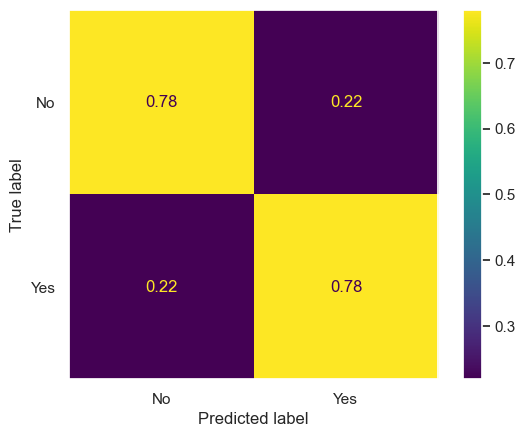

In [35]:
ConfusionMatrixDisplay.from_estimator(
    estimator=grid_search.best_estimator_,
    X=X,y=y,
    display_labels=le.classes_,    
    normalize="true"
)

plt.grid(False)
plt.show()

-  **Plano de ação**

1. Avaliar os motivos que levam os funcionários a fazerem hora extra, visto ser a principal caracte´ristica para `attrition`

    - Mão de obra insuficiente: setores engargalados;
    - Falta de organização institucional: processos difusos e complexos;
    - Falta de treinamento: colaboradores levam mais tempo do que deveriam nas tarefas;
    - Necessidade de investimento em tecnologia: automações e simplificações na comunicação

- Possibilidade de diminuir as viagens de negócios.
  - Como isso afeta a equipe de vendas?
  - será que todas as visitas presenciais são necessárias? Existem alternativas à distância?

- Como a renda mensal de cada setor e nível da empresa se compara com o mercado?  
    - Uma vez que esse é um fator de retenção, será que é o momento de revisitar os salários para equalizar valores de mercado?
